# $\textit{Task for Meet at 9 August 2022}$

In [43]:
# importing all necessary library

from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
# importing csv file of 1m sources containing Gaia data for plotting HR diagram
filename = '1M.csv'
df1 = pd.read_csv(filename)

# filtering data on the basis of parallax error so that we can get better observed sources
df = df1[df1['parallax_error']< 0.1]
df = df.reset_index(drop=True)
# extracting the value of G-K filter
g_k_1m = df['phot_g_mean_mag'] - df['ks_m']

## $\textbf{Considering only those stars which are in "external.gaiaedr3\_distance" table }$

In [1]:
# defining a function for extracting data of stars from GAIA database around a choosen Object(Star or Herbig Ae/Be star)

# The function will take input query size, ra, dec of the centered boject and radius of the circle
# It will give output of ojects around that star in table form

def get_gaia_result(query_size, ra_obj, dec_obj, radius_deg):
    #from astroquery.gaia import Gaia

    query = """SELECT TOP {}""".format(query_size) + """
        g.source_id, g.ra, g.dec, g.parallax, g.parallax_error, d3.r_med_geo, d3.r_med_photogeo, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv,
        w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro, tt.j_m, tt.h_m, tt.ks_m
        FROM gaiadr2.gaia_source as g, gaiadr2.allwise_best_neighbour as x, allwise_original_valid as w, gaiadr2.tmass_best_neighbour as t, tmass_original_valid as tt, external.gaiaedr3_distance AS d3
        WHERE CONTAINS(POINT(g.ra, g.dec), CIRCLE({}""".format(ra_obj) + """, {}""".format(dec_obj)+""", {}""".format(radius_deg) + """ )) = 1 AND g.parallax > 0.0 AND
        g.parallax IS NOT NULL AND g.bp_rp IS NOT NULL AND ((g.source_id = x.source_id AND x.allwise_oid = w.allwise_oid) AND (g.source_id = t.source_id AND t.tmass_oid = tt.tmass_oid)) AND (g.source_id = d3.source_id)
        """

    job = Gaia.launch_job(query)
    result = job.get_results()

    return result

### Testing our defined function and getting gaia result around a herbig star

In [4]:
herbig_test = get_gaia_result(1000, 193.3217131, -77.1196488, 12./60.)
herbig_test = herbig_test[herbig_test['parallax_error'] < 0.3]

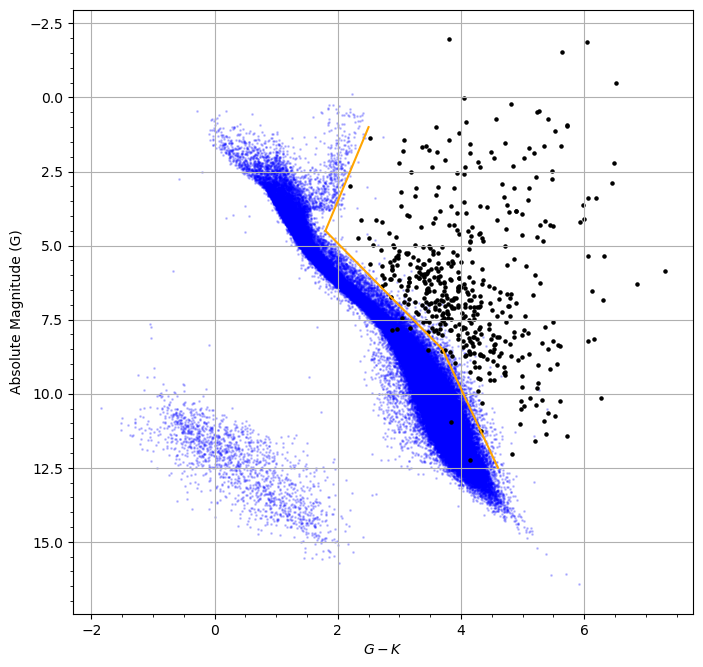

In [5]:
# getting Absolute and G - K filter value for all stars

her_gk = herbig_test['phot_g_mean_mag'] - herbig_test['ks_m']
her_mg = herbig_test['mv']



# Defining tand her_mg[i] < 12.5he equation of straight line for the boundries

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x

# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 12.5, 100)

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

# Plotting HR diagram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)
ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

# plotting the lines using just two points 
# ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
# ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
# ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = 'orange')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')
ax.plot(equation3(y_values3), y_values3, color = 'orange')

# plotting/Placing herbig's surrounding stars in HR diagram(CMD)
ax.scatter(her_gk, her_mg, marker='o', color = 'k', s = 5, label = 'HAeBe')

ax.minorticks_on()
ax.grid(True)
ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
plt.show()


### Counting function

In [1]:
# Defining a function which will count red object
# just we need to pass list of object(stars) with G-K as X- coordinate and Absolute Magnitude(Mv) as Y-coordinate 

def counting_fun(her_mg, her_gk):

    count_red = 0

    for i in range(len(her_mg)):

        if her_mg[i] <= 4.5:
            if her_gk[i] >= equation1(her_mg[i]):
                count_red = count_red + 1
        
        if 4.5 < her_mg[i] and her_mg[i] <= 8.5:
            if her_gk[i] >= equation2(her_mg[i]):
                count_red = count_red + 1

        if 8.5 < her_mg[i]:
            if her_gk[i] >= equation3(her_mg[i]):
                count_red = count_red + 1


    return count_red

In [7]:
n_star = counting_fun(her_mg, her_gk)
print("total no of red star = {}".format(n_star))

print(len(her_gk), len(her_mg))
print("Fraction of red star ={}".format(n_star/len(her_gk)))

total no of red star = 454
464 464
Fraction of red star =0.978448275862069


### For a random star, finding all the surrounding star and counting them

In [8]:
rand_star = get_gaia_result(1000, 72.77801742, 0.546141291, 12./60.)
rand_star = rand_star[rand_star['parallax_error']< 0.3]
rand_gk = rand_star['phot_g_mean_mag'] - rand_star['ks_m']
rand_mg = rand_star['mv']
n_star = counting_fun(rand_mg, rand_gk)
n_star

33

### Plotting these random star in HR diagram

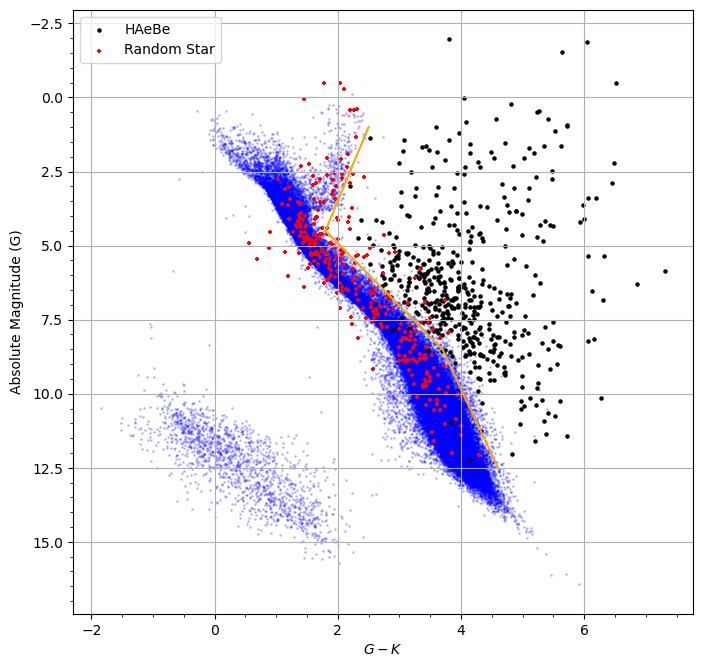

In [9]:
# getting Absolute and G - K filter value for all stars
her_gk = herbig_test['phot_g_mean_mag'] - herbig_test['ks_m']
her_mg = herbig_test['mv']

# Defining the equation of straight line for the boundries

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------


def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------


y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 12.5, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)
ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)")
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

# ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
# ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
# ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')


# Drawing the boundary line
ax.plot(equation1(y_values1), y_values1,  color = 'orange')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')
ax.plot(equation3(y_values3), y_values3, color = 'orange')


# for herbig star
ax.scatter(her_gk, her_mg, marker='o', color = 'k', s = 5, label = 'HAeBe')
# for random star
ax.scatter(rand_gk, rand_mg, marker='+', color = 'red', s = 5, label = 'Random Star')

ax.minorticks_on()
ax.grid(True)
ax.legend()
ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
plt.show()


### Importing 20 random Ae/Be stars and 20 Random stars

In [38]:
# importing 20 Herbig Stars

herbig_list = pd.read_csv("Herbig20.csv")
herbig_20 = herbig_list[["Name", "RAICRS", "DEICRS", "Dist"]]
herbig_20 = herbig_20.sort_values(by = 'Dist') 
herbig_20 = herbig_20.reset_index(drop=True)


# taking 20 random stars from Gaia Database
randstar_20 = pd.read_csv("random22.csv")


In [39]:
randstar_20

,source_id,ra,dec,parallax,parallax_error,r_med_geo,r_med_photogeo,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,w1mpro,w2mpro,w3mpro,w4mpro,j_m,h_m,ks_m
0,1421428123921969536,265.500670,57.037785,1.771803,0.009142,551.20720,550.87060,13.068459,13.381676,12.596739,0.784937,4.310536,11.687,11.717,11.510,9.750,12.049,11.720,11.736
1,4653986124831923456,65.803654,-71.690995,1.289846,0.009311,752.52410,752.64020,13.183333,13.493254,12.709017,0.784237,3.736024,11.785,11.806,11.601,9.155,12.131,11.873,11.823
2,2159226883158029952,271.239329,61.771907,3.943005,0.009389,250.82490,250.82062,13.196609,13.749046,12.515802,1.233244,6.175745,11.039,11.119,10.908,9.009,11.680,11.189,11.098
3,2293637128772067840,280.774405,78.096764,2.321574,0.009426,424.73572,424.86610,13.188673,13.596359,12.627187,0.969172,5.017585,11.448,11.470,11.417,9.618,11.935,11.570,11.515
4,4760504303069565056,79.352563,-61.915871,3.634955,0.009430,273.49863,273.53613,13.186937,13.661277,12.568212,1.093065,5.989433,11.205,11.247,11.205,10.127,11.818,11.418,11.272
5,5278259449510557824,91.845779,-71.863904,0.224943,0.009441,3782.16550,3738.43730,13.193015,13.806603,12.453834,1.352770,-0.046626,10.655,10.736,10.656,9.863,11.485,10.917,10.789
6,5285214204149802112,104.173372,-64.801168,1.156184,0.009463,836.11426,837.77890,13.237310,13.516376,12.805569,0.710807,3.552446,11.966,12.008,11.791,8.858,12.320,12.101,12.071
7,5496901666015915776,101.556754,-55.464688,0.536449,0.009479,1714.80980,1713.84340,13.101081,13.676964,12.390030,1.286934,1.748724,10.700,10.765,10.677,9.363,11.429,10.903,10.770
8,2151854898212606464,272.821076,57.766109,2.691799,0.009515,363.51498,363.33392,13.584837,14.044125,12.984699,1.059425,5.735050,11.716,11.767,11.767,9.400,12.289,11.867,11.804
9,4761339244711034624,78.641164,-59.687983,0.944961,0.009525,1025.83570,1024.38040,13.206351,13.548652,12.702763,0.845889,3.083420,11.664,11.708,11.663,9.215,12.106,11.760,11.701


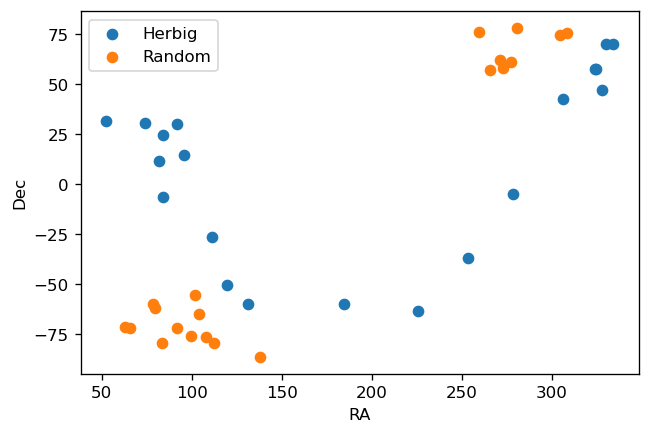

In [40]:
plt.figure(dpi = 120)
plt.scatter(herbig_20.RAICRS, herbig_20.DEICRS, label = 'Herbig')
plt.scatter(randstar_20.ra, randstar_20.dec, label = 'Random')
plt.legend()
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()


### # Plotting all 20 Herbig Ae/Be stars and 20 random stars in galactic coordinate system

In [41]:
one_coord = SkyCoord(df.ra, df.dec, unit = (u.deg, u.deg))
herb_coord= SkyCoord(herbig_20.RAICRS, herbig_20.DEICRS, unit = (u.deg, u.deg))
rand_coord = SkyCoord(randstar_20.ra, randstar_20.dec, unit = (u.deg, u.deg))


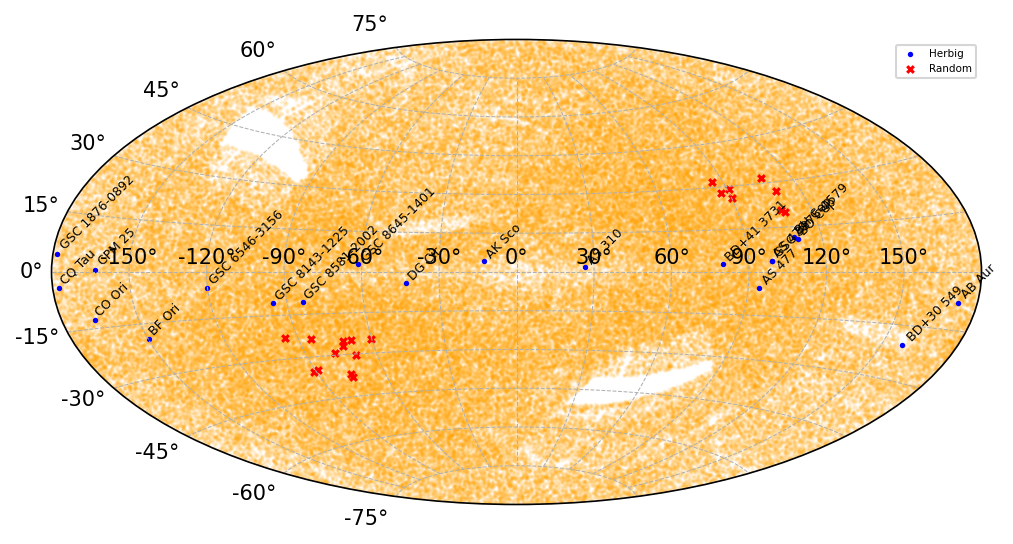

In [42]:
# Converting to galactic coordinate in degrees

one_gal = one_coord.transform_to('galactic')
herb_gal = herb_coord.transform_to('galactic')
rand_gal = rand_coord.transform_to('galactic')


l_one = one_gal.l.radian
l_one[l_one > np.pi] -= 2.0*np.pi
b_one = one_gal.b.radian


l_herb = herb_gal.l.radian
l_herb[l_herb > np.pi] -= 2.0*np.pi
b_herb = herb_gal.b.radian


l_rand = rand_gal.l.radian
l_rand[l_rand > np.pi] -= 2.0*np.pi
b_rand = rand_gal.b.radian


fig = plt.figure(figsize = [8, 5], dpi = 150)
ax = fig.add_subplot(1, 1, 1, projection='aitoff')
ax.scatter(l_one, b_one, s = 1, color = 'orange', alpha = 0.1 )
ax.scatter(l_herb, b_herb, s = 10, color ='blue', marker = '.', label = 'Herbig')
ax.scatter(l_rand, b_rand, s = 10, color = 'red', marker = "x", label = 'Random')
for i in range(len(l_herb)):
    ax.text(l_herb[i], b_herb[i]+ 0.02, '{}'.format(herbig_20.Name[i]), fontsize = 6, rotation = 45)
ax.legend(fontsize = 5)
ax.minorticks_on()
ax.grid(True, linewidth = 0.5, linestyle = '--')
# plt.savefig('posi.pdf', dpi = 500)
plt.show()

### defing a function to get the corresponding search radius for a distance star

Assuming "Orion Nebula" as base distance = 412 pc and radius = 12 ly = 3.679 pc, this leads to angular size = 30.7 arcminute.

Our search radius = 6.0 arcminute

In [15]:
def get_arc_min(dist_star_pc):
    theta_ini = 6.0 # In arcminute
    # dd = get_distance_of_single(5788943567946493312)  # In parsec
    # dist_ini = float(dd['r_med_geo'])
    dist_ini = 412   # In parsec
    theta_star = (dist_ini * theta_ini)/dist_star_pc

    return theta_star       # it returns parallax in arcminute

### Getting distance of a star using source_id from "external.gaiadr3_distance" catalog

In [16]:
# For single gaia object
def get_distance_of_single(source_id):
    
    query = """ SELECT g.source_id, g.ra, g.dec, d3.r_med_geo, d3.r_med_photogeo
        FROM gaiadr3.gaia_source AS g JOIN external.gaiaedr3_distance AS d3 ON (g.source_id = d3.source_id)
        WHERE g.source_id in ({})""".format(source_id)

    job = Gaia.launch_job(query)
    res = job.get_results()
        
    return res

In [17]:
dist_star = get_distance_of_single(source_id = randstar_20["source_id"][16])
dist_star = float(dist_star["r_med_geo"])
dist_star

99.63594055175781

In [18]:
dist_star = get_distance_of_single(source_id=randstar_20["source_id"][5])
dist_star = float(dist_star["r_med_geo"])
radius = get_arc_min(dist_star)
dd = get_gaia_result(10000, randstar_20["ra"][5], randstar_20['dec'][5], radius/60.0)

In [19]:
radius

24.6305500174423

In [20]:
radius
dd = dd[dd["parallax_error"] < 0.3]
dd

source_id,ra,dec,parallax,parallax_error,r_med_geo,r_med_photogeo,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,w1mpro,w2mpro,w3mpro,w4mpro,j_m,h_m,ks_m
,deg,deg,mas,mas,pc,pc,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32
6074915650307012480,192.61159369686217,-53.06078004017139,0.8474596299524144,0.051913772997078333,1154.7323,1162.3728,15.496981,15.942835,14.895346,1.0474892,5.13757576251353,13.743,13.865,13.035,9.422,14.168,13.823,13.705
6074929497275050112,192.29765201013785,-53.04567664333145,0.5230646096369856,0.20793524415750786,5378.4473,2902.2483,18.237087,18.834673,17.47792,1.3567524,6.829863933822338,16.017,16.472,12.978,9.506,16.481,15.882,15.404
6074929836570958080,192.3582072262773,-53.031616972861826,0.2011843675272229,0.14218869529883865,3972.9045,3495.5605,17.645908,18.107908,17.022987,1.0849209,4.163879515951855,15.908,16.767,12.354,9.454,16.352,16.026,15.347
6074926263157984640,192.26786800561536,-53.10452637306971,0.45757369961345673,0.20625188366168049,2353.1191,3071.5732,18.237692,18.744623,17.568602,1.1760216,6.5399971500569904,16.247,17.66,12.85,9.527,16.648,16.156,16.946
6074929492972167936,192.3045308387284,-53.040977389618035,0.4607379841289147,0.03193094855784475,1870.4469,1862.6029,13.756636,14.046922,13.306512,0.74040985,2.0739057549144473,12.46,12.461,12.401,9.302,12.775,12.553,12.489
6074923381248067328,192.19294238371367,-53.1066245035578,0.8982048524017789,0.04729174715382328,1177.9565,1174.6483,15.330582,15.736186,14.764587,0.9715986,5.097458649721441,13.628,13.688,12.989,9.528,14.105,13.731,13.72
6074928638288174336,192.538494574121,-52.97192881097889,1.0225097734393618,0.06279353106449882,947.96643,949.9996,16.120253,16.605894,15.478135,1.127759,6.168589948300188,14.176,14.392,13.016,9.327,14.713,14.183,14.12
6074927946785431808,192.59368391389663,-52.99196222091462,0.22439374296715814,0.1841649931182314,6061.401,4769.4775,18.150753,18.635323,17.485968,1.1493549,4.905806735303409,16.436,17.417,13.027,9.307,16.763,16.241,17.003


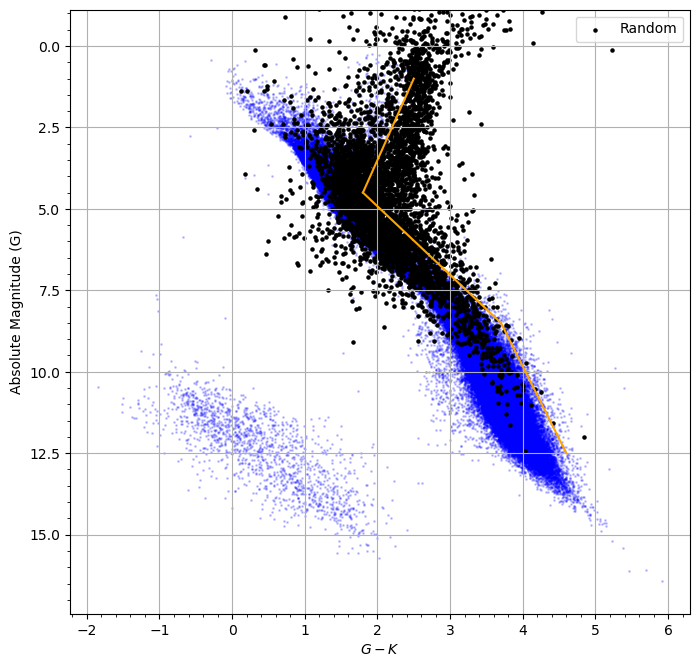

In [21]:
# %matplotlib inline

# Obtaining G-K and Absolute Magnitue (Mv) for Random star and Herbig Ae/Be Star
rand_gk = dd['phot_g_mean_mag'] - dd['ks_m']
rand_mg = dd['mv']

# her_gk = result_her["phot_g_mean_mag"] - result_her['ks_m']
# her_mg = result_her["mv"]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)


ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

# plotting the lines using just two points 

# ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
# ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
# ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = 'orange')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')
ax.plot(equation3(y_values3), y_values3, color = 'orange')

# plotting/Placing herbig's surrounding stars in HR diagram(CMD)
ax.scatter(rand_gk, rand_mg, marker='o', color = 'k', s = 5, label = 'Random')
# ax.scatter(her_gk, her_mg, marker='+', color = 'r', s = 5, label = 'HAeBe')

ax.minorticks_on()
ax.grid(True)
ax.legend()
ax.set_ylim(max(df.mg)+1, min(df.mg) -1)
plt.show()

In [22]:
n_star = counting_fun(rand_mg, rand_gk)
n_star

1523

In [23]:
dd = dd[(dd["r_med_geo"] > 2000)]
dd

source_id,ra,dec,parallax,parallax_error,r_med_geo,r_med_photogeo,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,w1mpro,w2mpro,w3mpro,w4mpro,j_m,h_m,ks_m
,deg,deg,mas,mas,pc,pc,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32
6074929497275050112,192.29765201013785,-53.04567664333145,0.5230646096369856,0.20793524415750786,5378.4473,2902.2483,18.237087,18.834673,17.47792,1.3567524,6.829863933822338,16.017,16.472,12.978,9.506,16.481,15.882,15.404
6074929836570958080,192.3582072262773,-53.031616972861826,0.2011843675272229,0.14218869529883865,3972.9045,3495.5605,17.645908,18.107908,17.022987,1.0849209,4.163879515951855,15.908,16.767,12.354,9.454,16.352,16.026,15.347
6074926263157984640,192.26786800561536,-53.10452637306971,0.45757369961345673,0.20625188366168049,2353.1191,3071.5732,18.237692,18.744623,17.568602,1.1760216,6.5399971500569904,16.247,17.66,12.85,9.527,16.648,16.156,16.946
6074927946785431808,192.59368391389663,-52.99196222091462,0.22439374296715814,0.1841649931182314,6061.401,4769.4775,18.150753,18.635323,17.485968,1.1493549,4.905806735303409,16.436,17.417,13.027,9.307,16.763,16.241,17.003
6074930356275091712,192.40019557170965,-52.95836808602493,0.4514302335185436,0.07444257966530379,2077.1467,2043.6989,16.387295,16.86682,15.730248,1.1365709,4.660247977317688,14.309,14.339,12.721,9.245,14.938,14.397,14.526
6074913588722638080,192.46663633094428,-53.127858917749066,0.23525240989173965,0.027535038426204965,3737.7568,3719.8508,13.181485,14.263528,12.156206,2.1073217,0.0391555809468489,9.459,9.654,9.465,9.314,10.626,9.829,9.587
6074924171522054528,192.04892484287916,-53.084250394131885,0.4448257780153391,0.12616812510044115,2511.1948,2444.1492,17.215519,17.728964,16.551693,1.1772709,5.456468686523241,15.306,15.655,12.638,9.041,15.705,15.264,15.242
6074923518687025280,192.1574905522296,-53.09653649483848,0.37979525666351754,0.10317380974515807,2084.8938,2157.613,17.013884,17.527746,16.370333,1.1574135,4.911631272933304,15.125,15.649,12.743,9.346,15.57,15.131,14.881


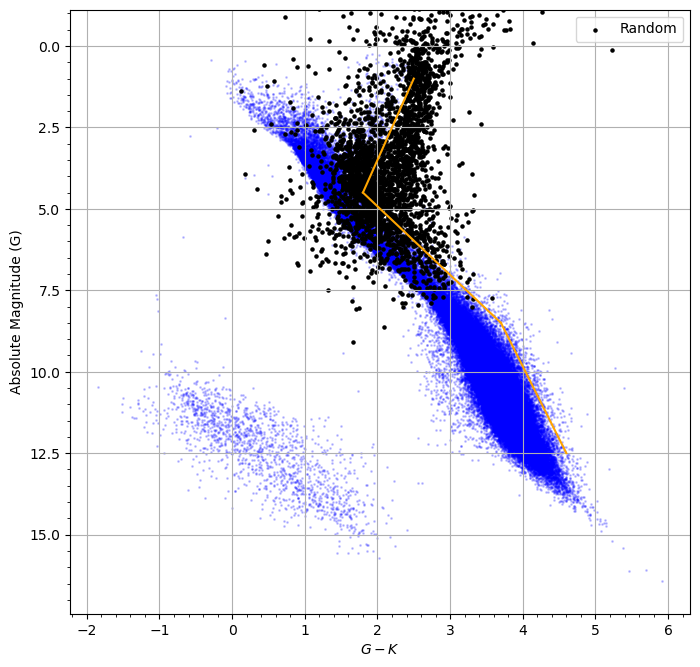

In [24]:
# %matplotlib inline

# Obtaining G-K and Absolute Magnitue (Mv) for Random star and Herbig Ae/Be Star
rand_gk = dd['phot_g_mean_mag'] - dd['ks_m']
rand_mg = dd['mv']

# her_gk = result_her["phot_g_mean_mag"] - result_her['ks_m']
# her_mg = result_her["mv"]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)


ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

# plotting the lines using just two points 

# ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
# ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
# ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = 'orange')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')
ax.plot(equation3(y_values3), y_values3, color = 'orange')

# plotting/Placing herbig's surrounding stars in HR diagram(CMD)
ax.scatter(rand_gk, rand_mg, marker='o', color = 'k', s = 5, label = 'Random')
# ax.scatter(her_gk, her_mg, marker='+', color = 'r', s = 5, label = 'HAeBe')

ax.minorticks_on()
ax.grid(True)
ax.legend()
ax.set_ylim(max(df.mg)+1, min(df.mg) -1)
plt.show()

In [25]:
n_star = counting_fun(rand_mg, rand_gk)
n_star

1292

### Defining boundary lines in G vs G-K plot

In [26]:
# Defining the equation of straight line for the boundries
def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x

# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 12.5, 100)

In [27]:
# Creating a list for storing the total number of stars around a Herbig Ae/Be star

num_tot_star_her = []  
num_red_star_her = []   # For red object around Herbig Ae/Be star
num_tot_star_rand = []  # For toatal star around random star
num_red_star_rand = []  # For red objec around the Random Star




for i in range(len(herbig_20["Dist"])):

    # ------------------------------------------------
    # -----------   RANDOM STAR    -------------------

    # getting distance of star from table external.gaiaedr3_distance
    dist_star = randstar_20["r_med_geo"][i]
    radius_star = get_arc_min(dist_star)    # this will give radius in arc minutes
    result_star = get_gaia_result(10000, randstar_20["ra"][i], randstar_20['dec'][i], radius_star/60.0) # this will give radius in arc minutes 

    # Filter condition
    result_star = result_star[result_star["parallax_error"] < 0.3]


    filter_dist_star = 0.8
    max_dist_star = dist_star + dist_star * filter_dist_star 
    min_dist_star = dist_star - dist_star * filter_dist_star 
    result_star = result_star[(result_star["r_med_geo"] < max_dist_star) & (result_star["r_med_geo"] > min_dist_star)]

    # -----------------------------------------------------
    # -----------   HERBIG Ae/Be STAR    -------------------


    dist_her = herbig_20["Dist"][i]
    radius_her = get_arc_min(dist_star)  # this will give radius in arc minutes
    result_her = get_gaia_result(10000, herbig_20["RAICRS"][i], herbig_20['DEICRS'][i], radius_her/60.0)  # this will give radius in arc minutes
    
    # Filter condition
    result_her = result_her[result_her["parallax_error"] < 0.3]

    
    
    filter_dist_her = 0.8
    max_dist_her = dist_her + dist_her * filter_dist_her 
    min_dist_her = dist_her - dist_her * filter_dist_her 
    result_her = result_her[(result_her["r_med_geo"]<max_dist_her) & (result_her["r_med_geo"]>min_dist_her)]


    # %matplotlib inline

    # Obtaining G-K and Absolute Magnitue (Mv) for Random star and Herbig Ae/Be Star
    rand_gk = result_star['phot_g_mean_mag'] - result_star['ks_m']
    rand_mg = result_star['mv']

    her_gk = result_her["phot_g_mean_mag"] - result_her['ks_m']
    her_mg = result_her["mv"]


    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)


    # ax.set_xlabel(r"$G - K$")
    # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 10)

    # # Plotting the HR diagram for 1M sources
    # ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

    # # plotting the lines using just two points 

    # # ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
    # # ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
    # # ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

    # # plotting the boundries using the eqaution of straight line
    # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
    # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
    # ax.plot(equation3(y_values3), y_values3, color = 'orange')

    # # plotting/Placing herbig's surrounding stars in HR diagram(CMD)
    # ax.scatter(rand_gk, rand_mg, marker='o', color = 'k', s = 5, label = 'Random')
    # ax.scatter(her_gk, her_mg, marker='+', color = 'r', s = 5, label = 'HAeBe')

    # ax.minorticks_on()
    # ax.grid(True)
    # ax.legend()
    # ax.set_ylim(max(df.mg)+1, min(df.mg) -1)
    # plt.show()


    her_red_star = counting_fun(her_mg, her_gk)
    num_tot_star_her.append(len(her_mg))
    num_red_star_her.append(her_red_star)

    """ Counting Red Object around a Random Star"""

    rand_red_star = counting_fun(rand_mg, rand_gk)
    num_tot_star_rand.append(len(rand_mg))
    num_red_star_rand.append(rand_red_star)




In [28]:
print("\n")
print("-------------------------------   For Herbig Star    -----------------------------------")
print("\n")
print("Name of Herbig Star \t No of Red star    Total no of star    Probabaility of red object")
print("-----------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:10s}\t". format(herbig_20.loc[i][0]) + "\t \t {:3d}".format(num_red_star_her[i]) + "\t \t{:3d}".format(num_tot_star_her[i]) + "\t \t \t{:0.4f}".format(num_red_star_her[i]/num_tot_star_her[i]))

print("\n")
print(" Average number of red objects around a Herbig Star = ", np.average(num_red_star_her))


print(" ")


print("-----------------------------------------------------------------------------------------")
print("\n")
print("--------------------------------  For Random Star    ------------------------------------")
print("\n")
print("Sl. No. of Random Star \t No of Red star    Total no of star     Probability of red object")
print("------------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:2d}\t".format(i) + "\t \t {}\t".format(num_red_star_rand[i]) + "\t \t{}".format(num_tot_star_rand[i]) + "\t \t \t{:0.4f}".format(num_red_star_rand[i]/num_tot_star_rand[i]))

print("\n")

print(" Average number of red objects around a Random Star = ", np.average(num_red_star_rand))



-------------------------------   For Herbig Star    -----------------------------------


Name of Herbig Star 	 No of Red star    Total no of star    Probabaility of red object
-----------------------------------------------------------------------------------------
 AK Sco    		 	   3	 	 23	 	 	0.1304
 AB Aur    		 	  28	 	 59	 	 	0.4746
 CQ Tau    		 	   7	 	 52	 	 	0.1346
 BD+30 549 		 	  93	 	141	 	 	0.6596
 BH Cep    		 	  15	 	285	 	 	0.0526
 BO Cep    		 	  55	 	376	 	 	0.1463
 GSC 8143-1225		 	  82	 	423	 	 	0.1939
 BF Ori    		 	 260	 	382	 	 	0.6806
 CO Ori    		 	 100	 	312	 	 	0.3205
 GSC 8581-2002		 	 123	 	721	 	 	0.1706
 AS 477    		 	 485	 	1290	 	 	0.3760
 DG Cir    		 	 528	 	810	 	 	0.6519
 GSC 3975-0579		 	 1005	 	1572	 	 	0.6393
 BD+41 3731		 	 741	 	1257	 	 	0.5895
 GSC 6546-3156		 	 933	 	2871	 	 	0.3250
 GSC 8645-1401		 	 1331	 	2419	 	 	0.5502
 AS 310    		 	 1217	 	1253	 	 	0.9713
 CPM 25    		 	 1663	 	3963	 	 	0.4196
 GSC 1876-0892		 	 1658	 	2823	 	 	0.5

In [29]:
randstar_20

,source_id,ra,dec,parallax,parallax_error,r_med_geo,r_med_photogeo,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,w1mpro,w2mpro,w3mpro,w4mpro,j_m,h_m,ks_m
0,1769202380476257280,326.964971,14.825783,10.000008,0.033425,99.504715,99.485310,15.390248,16.919266,14.187394,2.731872,10.390250,11.563,11.399,11.349,8.982,12.485,11.918,11.680
1,518180210764160512,30.155441,65.266687,10.000029,0.012865,99.644390,99.610300,13.608475,14.623214,12.597395,2.025819,8.608481,10.362,10.310,10.076,8.358,11.291,10.671,10.470
2,473881441333817984,60.747614,60.727335,10.000032,0.013737,99.700190,99.737885,9.267752,9.624231,8.743373,0.880858,4.267759,7.734,7.804,7.768,7.759,8.187,7.833,7.757
3,6473748546781525888,303.303117,-52.782225,10.000051,0.198665,99.848015,96.991135,18.146105,20.622805,16.778101,3.844704,13.146116,13.688,13.439,12.693,9.183,14.734,14.150,13.853
4,71475475647268736,55.057709,28.350757,10.000066,0.048958,99.510574,99.516720,15.506643,16.973078,14.323343,2.649735,10.506658,11.713,11.550,11.362,8.539,12.734,12.105,11.874
5,6075136102374866560,192.176167,-52.762899,10.000102,0.470049,100.363170,101.421364,19.663582,21.206299,18.188667,3.017631,14.663604,14.445,14.332,12.458,9.133,15.527,15.010,14.700
6,4587157601940918656,278.889320,28.827333,10.000111,0.059937,99.550590,99.654410,17.077917,18.773182,15.832307,2.940875,12.077941,13.089,12.928,12.227,9.217,14.099,13.524,13.298
7,4799566167336113536,81.264014,-44.487143,10.000113,0.032224,99.928940,99.860770,8.968927,9.081850,8.355292,0.726558,3.968952,7.482,7.523,7.502,7.499,7.861,7.627,7.515
8,6832879006104020096,318.176814,-19.639974,10.000128,0.032527,99.536804,99.505760,14.719197,16.046291,13.585066,2.461225,9.719225,11.111,11.008,10.965,7.814,12.065,11.496,11.224
9,1407928457594520576,253.502181,47.883362,10.000129,0.019316,99.572876,99.648735,14.937911,16.300388,13.787047,2.513341,9.937939,11.335,11.163,11.014,9.141,12.263,11.684,11.448


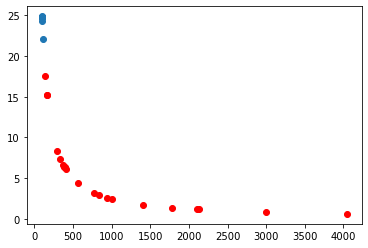

In [30]:


plt.scatter(randstar_20["r_med_geo"], get_arc_min(randstar_20["r_med_geo"]))
plt.scatter(herbig_20["Dist"], get_arc_min(herbig_20["Dist"]), c = 'r')
plt.show()

In [31]:
herbig_20.sort_values(by = 'Dist')
herbig_20 = herbig_20.reset_index(drop=True)
herbig_20

,Name,RAICRS,DEICRS,Dist
0,AK Sco,253.686667,-36.888611,140.6
1,AB Aur,73.941250,30.551111,162.9
2,CQ Tau,83.993750,24.748333,163.1
3,BD+30 549,52.332500,31.415833,295.4
4,BH Cep,330.428750,69.743333,335.1
5,BO Cep,334.225417,70.062500,374.5
6,GSC 8143-1225,119.798333,-50.379722,386.3
7,BF Ori,84.305417,-6.583611,388.8
8,CO Ori,81.909583,11.427500,404.0
9,GSC 8581-2002,131.098333,-59.949444,557.6


In [32]:
%matplotlib inline

def list_red_object(radius):

    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star


    for i in range(len(herbig_20.RAICRS)):
        
        

        herbig_star = get_gaia_result(1000, herbig_20.loc[i][1], herbig_20.loc[i][2], radius)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        rand_star = get_gaia_result(1000, randstar_20.loc[i][1], randstar_20.loc[i][2], radius)
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]

        y_values1 = np.linspace(1, 4.5, 50)
        y_values2 = np.linspace(4.5, 8.5, 100)
        y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe')

        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'green')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_vaplt.scatter(result["ra"], result["dec"])lues3, color = 'green')



        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)
        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)

        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)


        # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
        # print("Toatal surrounding stars = {}".format(len(her_mg)))


    # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
    # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
    # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
    # print("List red stars for 20 Random stplt.scatter(result["ra"], result["dec"]), num_red_star_rand, num_tot_star_rand
    
    
